# Imports

In [1]:
# import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
from time import time
from scipy.stats import pearsonr
from dataclasses import dataclass
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tf_datasets

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda, Layer
from tensorflow.keras import backend as K

from tensorflow.keras.utils import timeseries_dataset_from_array

import tensorflow_probability as tfp

import keras

#tf.debugging.disable_traceback_filtering()

tfd = tfp.distributions


# Load datasets

In [2]:
datasets, datasets_info = tf_datasets.load(name='mnist',
                                           with_info=True,
                                           as_supervised=False)

batch_size = 32*4 #*32

def _preprocess(sample):
    image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
    return image, image > tf.random.uniform(tf.shape(image))

train_dataset = (datasets['train']
                 .map(_preprocess)
                 .batch(batch_size)
                 .prefetch(tf.data.AUTOTUNE)
                #  .shuffle(int(10e3))          # very slow
                 )
eval_dataset = (datasets['test']
                .map(_preprocess)
                .batch(batch_size)
                .prefetch(tf.data.AUTOTUNE))


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


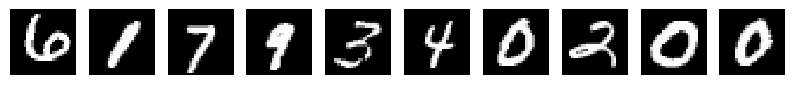

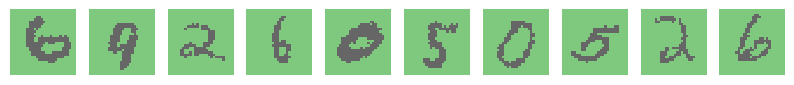

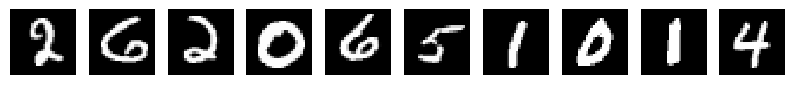

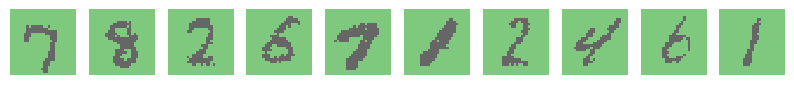

000: Accent


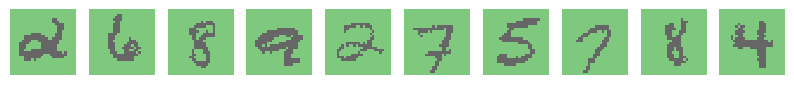

001: Accent_r


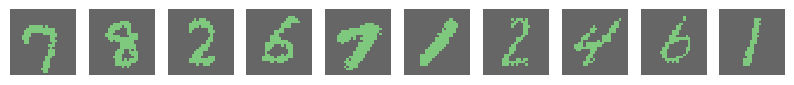

002: Blues


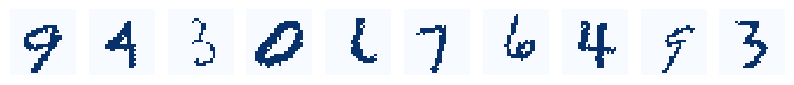

003: Blues_r


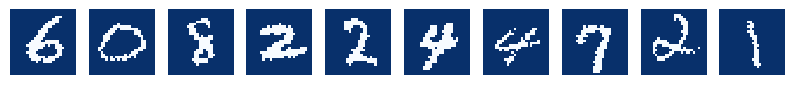

004: BrBG


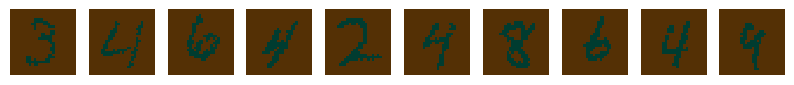

005: BrBG_r


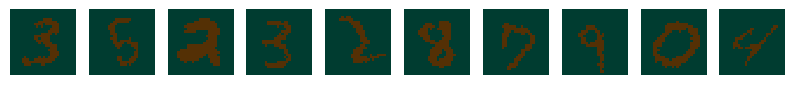

006: BuGn


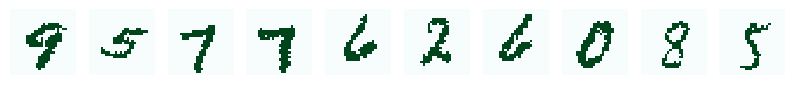

007: BuGn_r


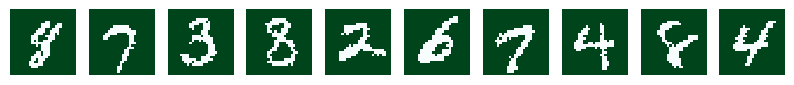

008: BuPu


KeyboardInterrupt: 

In [3]:


color_schemes = sorted(plt.colormaps())
# print(f"color_schemes: {color_schemes}")

def display_imgs(x, y=None, colorize=False):
    '''
    Display a batch of images.
    '''
    if isinstance(x, tf.data.Dataset):
        # print("x is a Dataset, converting to numpy")
        x = np.array(list(x.as_numpy_iterator()))
    # if isinstance(x, _TakeDataset)

    if not isinstance(x, (np.ndarray, np.generic)):
        if isinstance(x, tf.Tensor):
            # print("x is a Tensor, converting to numpy")
            x = x.numpy()
        else:
            if isinstance(x, tf.data.Iterator):
                # print("x is an iterator, converting to numpy")
                x = np.array(list(x))
            else:
                print("x is not a numpy object:", type(x))
                print("x is not a numpy object")
                x = np.array(x)
    plt.ioff()  # Turn off interactive mode to avoid blocking.
    # print(f"x.shape: {x.shape}")
    n = x.shape[0]  # Number of images to display.
    fig, axs = plt.subplots(1, n, figsize=(n, 1))  # Create a figure and axes.
    if isinstance(colorize, bool) and colorize:
        # Create a custom red-to-green colormap
        cdict = {'red':   [(0.0,  1.0, 1.0),
                        (1.0,  0.0, 0.0)],
                'green': [(0.0,  0.0, 0.0),
                        (1.0,  1.0, 1.0)],
                'blue':  [(0.0,  0.0, 0.0),
                        (1.0,  0.0, 0.0)]}
        cmap = LinearSegmentedColormap('RedGreen', cdict)
    elif isinstance(colorize, str):
        cmap = plt.get_cmap(colorize)
    elif not colorize is None and not isinstance(colorize, bool):
        raise ValueError(f"colorize must be a boolean or a string {type(colorize)}")
    else:
        cmap = 'gray'

    if y is not None:
        fig.suptitle(np.argmax(y, axis=1))  # Set the figure title.
    for i in range(n):
        axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap=cmap)  # Display the image.
        axs.flat[i].axis('off')  # Turn off axis labels.
    plt.show()   # Show the figure.
    plt.close()  # Close the figure to free up memory.
    plt.ion()    # Turn interactive mode back on.

display_imgs(list(train_dataset.shuffle(100).take(1))[0][0][:10])
display_imgs(list(train_dataset.shuffle(100).take(1))[0][1][:10], colorize="Accent")
display_imgs(list(eval_dataset.shuffle(100).take(1))[0][0][:10])
display_imgs(list(eval_dataset.shuffle(100).take(1))[0][1][:10], colorize=color_schemes[0])


for i, color in enumerate(color_schemes):
    print(f"{i:03d}: {color}")
    display_imgs(list(eval_dataset.shuffle(100).take(1))[0][1][:10], colorize=color)


# Variational autoencoder

In [4]:
input_shape = datasets_info.features['image'].shape
encoded_size = 16
base_depth = 32

print(f"input_shape: {input_shape}")
print(f"encoded_size: {encoded_size}")
print(f"base_depth: {base_depth}")
print(f"batch_size: {batch_size}")


input_shape: (28, 28, 1)
encoded_size: 16
base_depth: 32
batch_size: 128


In [5]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

print(f"prior: {prior}")

encoder = tfk.Sequential([
    tfk.layers.InputLayer(input_shape=input_shape),
    tfk.layers.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tfk.layers.Conv2D(
        base_depth, 5, strides=1,
        padding='same', activation=tf.nn.leaky_relu),
    tfk.layers.Conv2D(
        base_depth, 5, strides=2,
        padding='same', activation=tf.nn.leaky_relu),
    tfk.layers.Conv2D(
        2 * base_depth, 5, strides=1,
        padding='same', activation=tf.nn.leaky_relu),
    tfk.layers.Conv2D(
        2 * base_depth, 5, strides=2,
        padding='same', activation=tf.nn.leaky_relu),
    tfk.layers.Conv2D(
        4 * encoded_size, 7, strides=1,
        padding='valid', activation=tf.nn.leaky_relu),
    tfk.layers.Flatten(),
    tfk.layers.Dense(
        tfp.layers.MultivariateNormalTriL.params_size(encoded_size),
        activation=None),
    tfp.layers.MultivariateNormalTriL(
        encoded_size,
        activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior)),
])

print(f"encoder: {encoder}")
# encoder.summary()

decoder = tfk.Sequential([
    tfk.layers.InputLayer(input_shape=[encoded_size]),
    tfk.layers.Reshape([1, 1, encoded_size]),
    tfk.layers.Conv2DTranspose(
        2 * base_depth, 7, strides=1,
        padding='valid', activation=tf.nn.leaky_relu),
    tfk.layers.Conv2DTranspose(
        2 * base_depth, 5, strides=1,
        padding='same', activation=tf.nn.leaky_relu),
    tfk.layers.Conv2DTranspose(
        2 * base_depth, 5, strides=2,
        padding='same', activation=tf.nn.leaky_relu),
    tfk.layers.Conv2DTranspose(
        base_depth, 5, strides=1,
        padding='same', activation=tf.nn.leaky_relu),
    tfk.layers.Conv2DTranspose(
        base_depth, 5, strides=2,
        padding='same', activation=tf.nn.leaky_relu),
    tfk.layers.Conv2DTranspose(
        base_depth, 5, strides=1,
        padding='same', activation=tf.nn.leaky_relu),
    tfk.layers.Conv2D(
        filters=1, kernel_size=5, strides=1,
        padding='same', activation=None),
    tfk.layers.Flatten(),
    tfp.layers.IndependentBernoulli(input_shape, tfd.Bernoulli.logits),
])

print(f"decoder: {decoder}")
decoder.summary()


prior: tfp.distributions.Independent("IndependentNormal", batch_shape=[], event_shape=[16], dtype=float32)
encoder: <keras.src.engine.sequential.Sequential object at 0x78d49076b610>
decoder: <keras.src.engine.sequential.Sequential object at 0x78d4b254e350>
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 1, 16)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 64)          50240     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 7, 7, 64)          102464    
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 14, 14, 64)        102464

prior means: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
prior variances: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
vae: <keras.src.engine.functional.Functional object at 0x78d4d21e9360>
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 lambda (Lambda)             (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        25632     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        51264     
                                                          

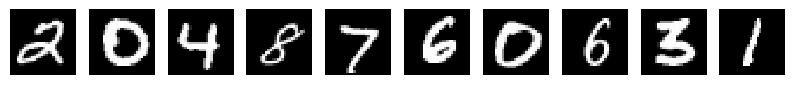

Reconstituted:


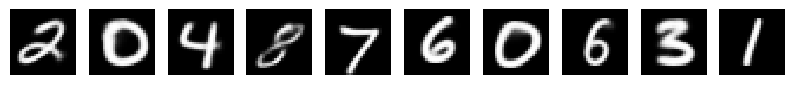

encoded_imgs: (10, 16)
Reconstituted from decoding the encoder:


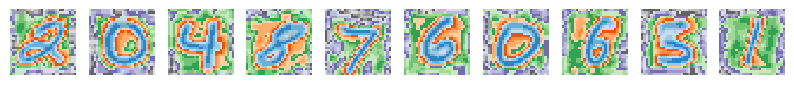

Epoch 1/30
467/469 [============================>.] - ETA: 0s - loss: 108.1634Original:


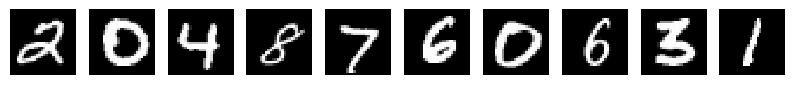

Embedding:


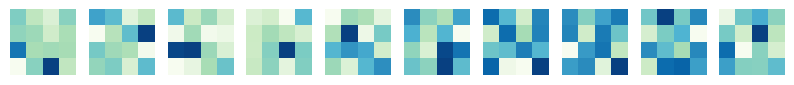

Embedding means:


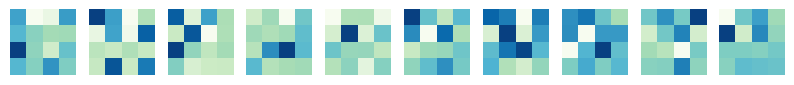

Embedding modes:


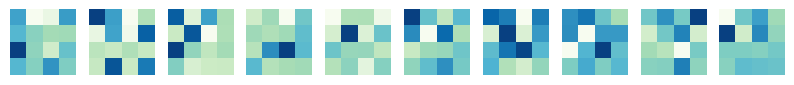

Embedding variances:


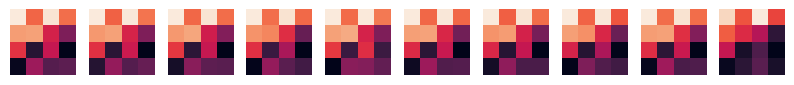

Reconstructions:


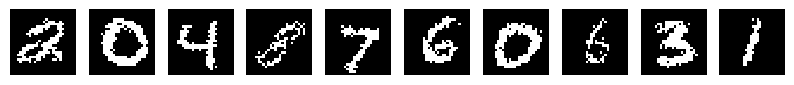

Decoded modes:


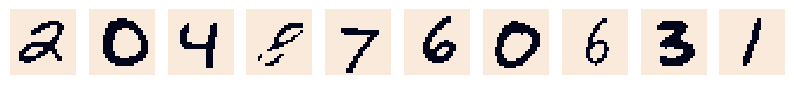

Decoded means:


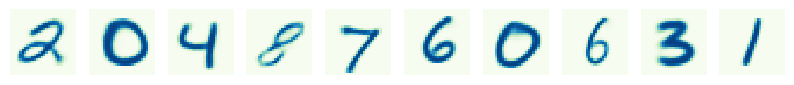

Decoded variances:


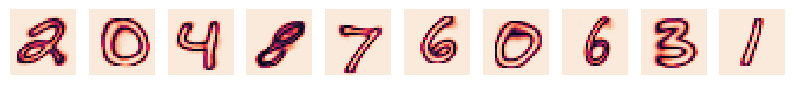

Confidence map?:


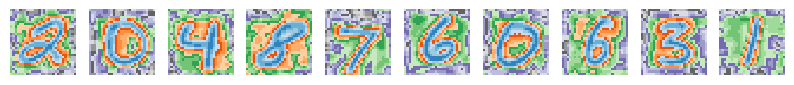


Epoch 1: val_loss improved from inf to 113.59248, saving model to models/model.113.6.keras
469/469 [==============================] - 16s 23ms/step - loss: 108.1507 - val_loss: 113.5925
Epoch 2/30
467/469 [============================>.] - ETA: 0s - loss: 108.2144Embedding variances:


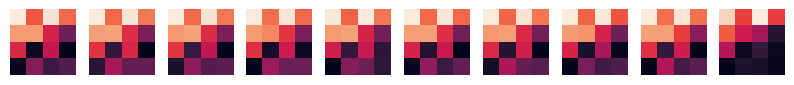


Epoch 2: val_loss did not improve from 113.59248
469/469 [==============================] - 6s 14ms/step - loss: 108.2000 - val_loss: 113.7946
Epoch 3/30
467/469 [============================>.] - ETA: 0s - loss: 108.0637Embedding variances:


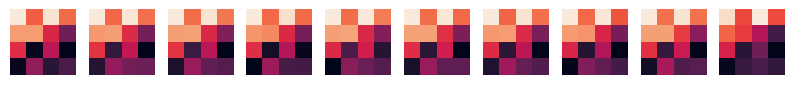


Epoch 3: val_loss did not improve from 113.59248
469/469 [==============================] - 6s 14ms/step - loss: 108.0539 - val_loss: 113.7928
Epoch 4/30
467/469 [============================>.] - ETA: 0s - loss: 108.0176Embedding variances:


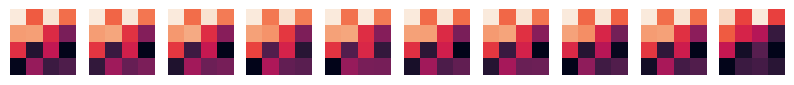


Epoch 4: val_loss did not improve from 113.59248
469/469 [==============================] - 6s 14ms/step - loss: 108.0015 - val_loss: 113.6568
Epoch 5/30
466/469 [============================>.] - ETA: 0s - loss: 107.8777Embedding variances:


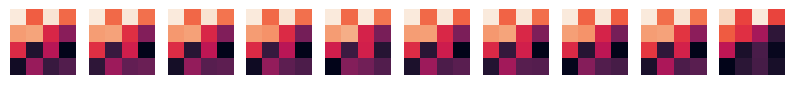


Epoch 5: val_loss did not improve from 113.59248
469/469 [==============================] - 6s 14ms/step - loss: 107.8635 - val_loss: 113.7088
Epoch 6/30
467/469 [============================>.] - ETA: 0s - loss: 107.7613Embedding variances:


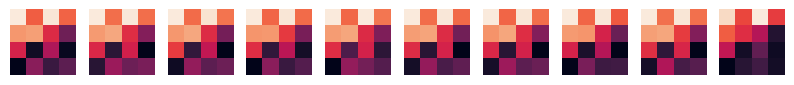


Epoch 6: val_loss did not improve from 113.59248
469/469 [==============================] - 6s 13ms/step - loss: 107.7483 - val_loss: 113.6292
Epoch 7/30
466/469 [============================>.] - ETA: 0s - loss: 107.6522Embedding variances:


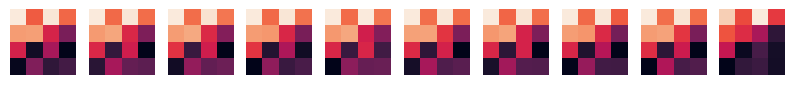


Epoch 7: val_loss improved from 113.59248 to 113.28213, saving model to models/model.113.3.keras
469/469 [==============================] - 7s 14ms/step - loss: 107.6355 - val_loss: 113.2821
Epoch 8/30
465/469 [============================>.] - ETA: 0s - loss: 107.5568Embedding variances:


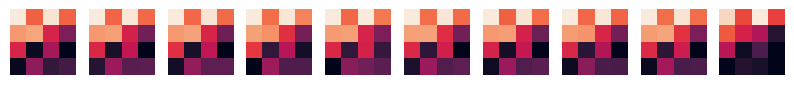


Epoch 8: val_loss did not improve from 113.28213
469/469 [==============================] - 6s 13ms/step - loss: 107.5373 - val_loss: 113.3745
Epoch 9/30
466/469 [============================>.] - ETA: 0s - loss: 107.4441Embedding variances:


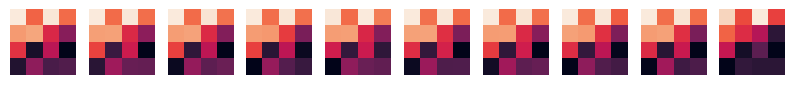


Epoch 9: val_loss did not improve from 113.28213
469/469 [==============================] - 7s 14ms/step - loss: 107.4300 - val_loss: 113.4983
Epoch 10/30
464/469 [============================>.] - ETA: 0s - loss: 107.2429Embedding variances:


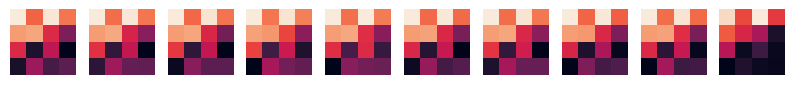


Epoch 10: val_loss did not improve from 113.28213
469/469 [==============================] - 6s 13ms/step - loss: 107.2331 - val_loss: 113.4260
Epoch 11/30
465/469 [============================>.] - ETA: 0s - loss: 107.2480Original:


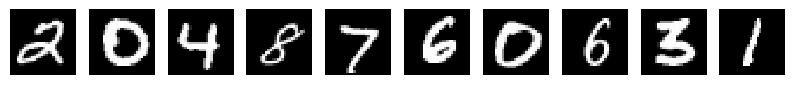

Embedding:


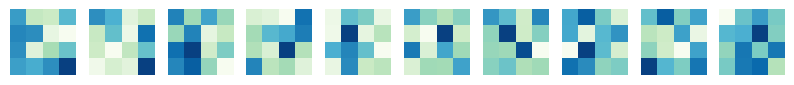

Embedding means:


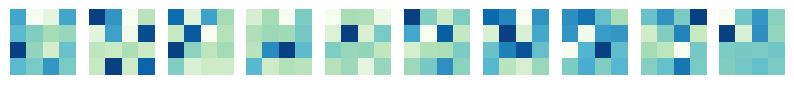

Embedding modes:


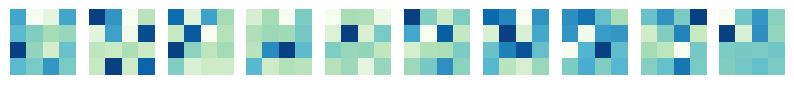

Embedding variances:


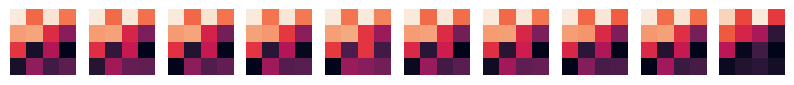

Reconstructions:


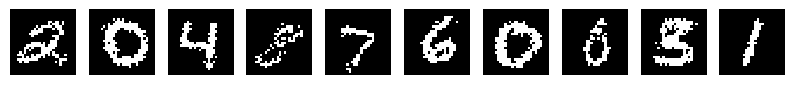

Decoded modes:


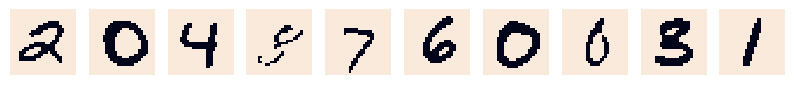

Decoded means:


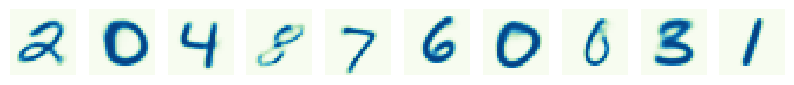

Decoded variances:


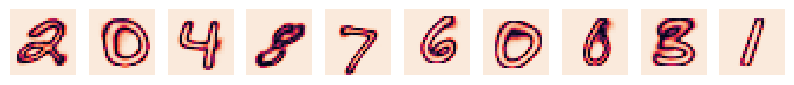

Confidence map?:


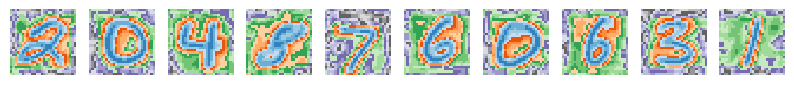


Epoch 11: val_loss improved from 113.28213 to 113.20036, saving model to models/model.113.2.keras
469/469 [==============================] - 12s 25ms/step - loss: 107.2309 - val_loss: 113.2004
Epoch 12/30
467/469 [============================>.] - ETA: 0s - loss: 107.1107Embedding variances:


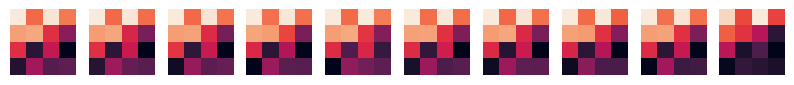


Epoch 12: val_loss did not improve from 113.20036
469/469 [==============================] - 6s 13ms/step - loss: 107.1009 - val_loss: 113.2822
Epoch 13/30
467/469 [============================>.] - ETA: 0s - loss: 106.9993Embedding variances:


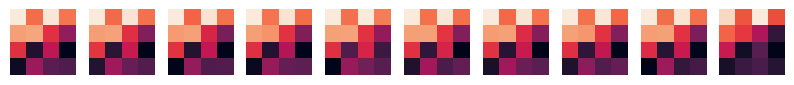


Epoch 13: val_loss did not improve from 113.20036
469/469 [==============================] - 6s 13ms/step - loss: 106.9884 - val_loss: 113.3597
Epoch 14/30
468/469 [============================>.] - ETA: 0s - loss: 106.8884Embedding variances:


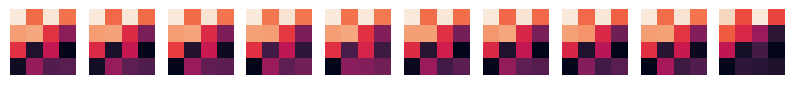


Epoch 14: val_loss improved from 113.20036 to 113.08276, saving model to models/model.113.1.keras
469/469 [==============================] - 6s 14ms/step - loss: 106.8761 - val_loss: 113.0828
Epoch 15/30
468/469 [============================>.] - ETA: 0s - loss: 106.8247Embedding variances:


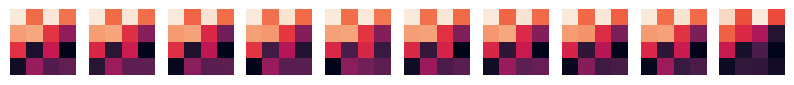


Epoch 15: val_loss did not improve from 113.08276
469/469 [==============================] - 6s 14ms/step - loss: 106.8128 - val_loss: 113.1882
Epoch 16/30
467/469 [============================>.] - ETA: 0s - loss: 106.6287Embedding variances:


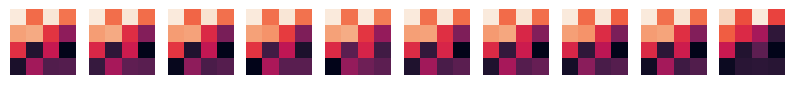


Epoch 16: val_loss improved from 113.08276 to 112.97886, saving model to models/model.113.0.keras
469/469 [==============================] - 7s 14ms/step - loss: 106.6172 - val_loss: 112.9789
Epoch 17/30
466/469 [============================>.] - ETA: 0s - loss: 106.6408Embedding variances:


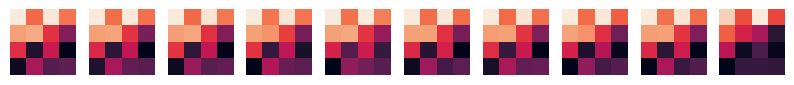


Epoch 17: val_loss did not improve from 112.97886
469/469 [==============================] - 6s 13ms/step - loss: 106.6318 - val_loss: 113.3091
Epoch 18/30
466/469 [============================>.] - ETA: 0s - loss: 106.5328Embedding variances:


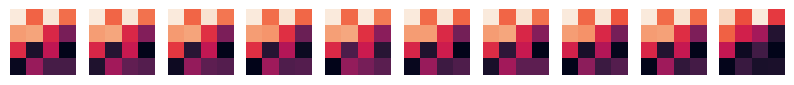


Epoch 18: val_loss did not improve from 112.97886
469/469 [==============================] - 6s 14ms/step - loss: 106.5237 - val_loss: 113.0309
Epoch 19/30
465/469 [============================>.] - ETA: 0s - loss: 106.4136Embedding variances:


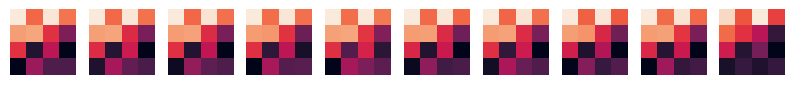


Epoch 19: val_loss did not improve from 112.97886
469/469 [==============================] - 6s 13ms/step - loss: 106.3927 - val_loss: 113.3626
Epoch 20/30
469/469 [==============================] - ETA: 0s - loss: 106.3389Embedding variances:


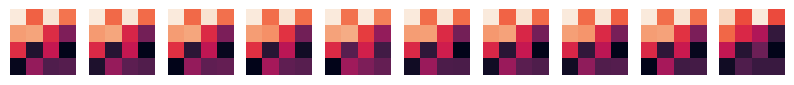


Epoch 20: val_loss did not improve from 112.97886
469/469 [==============================] - 6s 13ms/step - loss: 106.3389 - val_loss: 113.2192
Epoch 21/30
465/469 [============================>.] - ETA: 0s - loss: 106.3075Original:


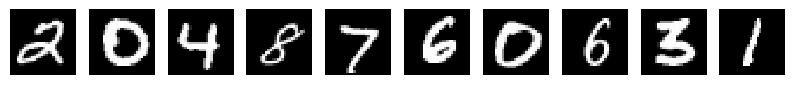

Embedding:


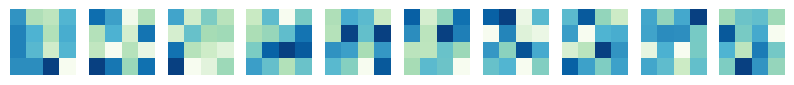

Embedding means:


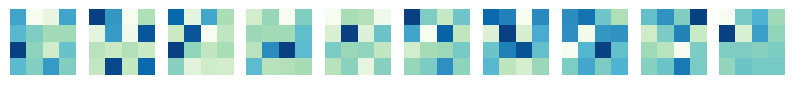

Embedding modes:


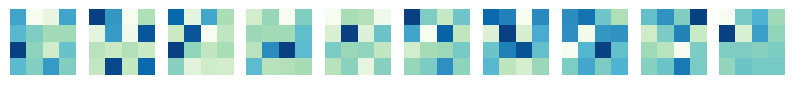

Embedding variances:


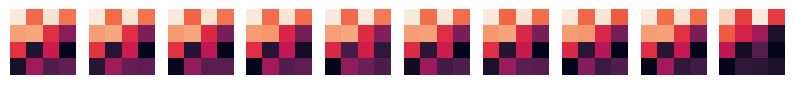

Reconstructions:


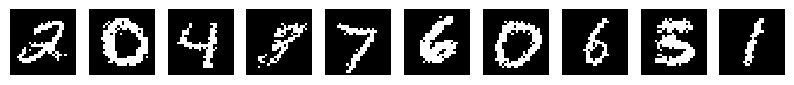

Decoded modes:


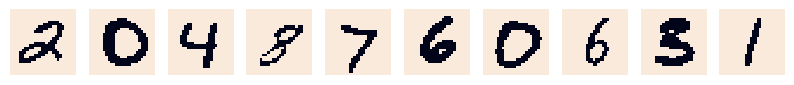

Decoded means:


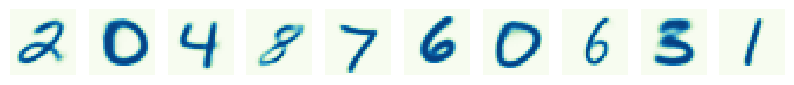

Decoded variances:


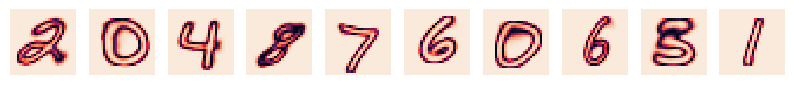

Confidence map?:


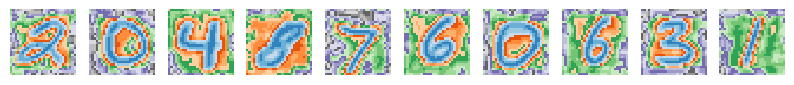


Epoch 21: val_loss improved from 112.97886 to 112.91110, saving model to models/model.112.9.keras
469/469 [==============================] - 10s 21ms/step - loss: 106.2933 - val_loss: 112.9111
Epoch 22/30
467/469 [============================>.] - ETA: 0s - loss: 106.2044Embedding variances:


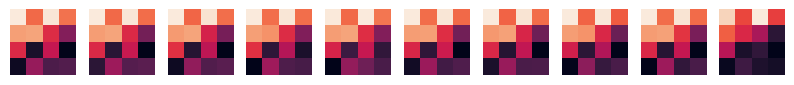


Epoch 22: val_loss did not improve from 112.91110
469/469 [==============================] - 6s 14ms/step - loss: 106.1910 - val_loss: 113.2396
Epoch 23/30
468/469 [============================>.] - ETA: 0s - loss: 106.1431Embedding variances:


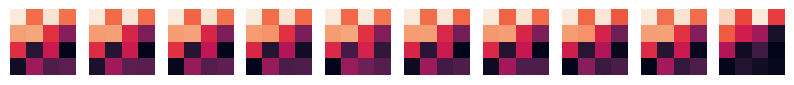


Epoch 23: val_loss improved from 112.91110 to 112.90224, saving model to models/model.112.9.keras
469/469 [==============================] - 7s 14ms/step - loss: 106.1297 - val_loss: 112.9022
Epoch 24/30
468/469 [============================>.] - ETA: 0s - loss: 106.0765Embedding variances:


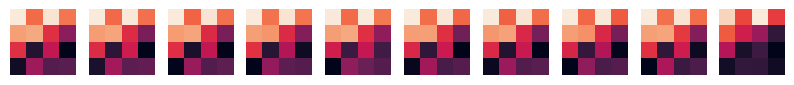


Epoch 24: val_loss did not improve from 112.90224
469/469 [==============================] - 9s 19ms/step - loss: 106.0615 - val_loss: 113.0525
Epoch 25/30
466/469 [============================>.] - ETA: 0s - loss: 106.0167Embedding variances:


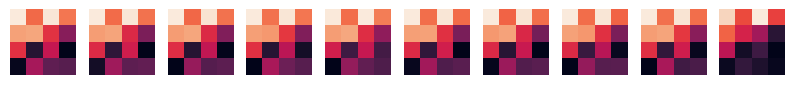


Epoch 25: val_loss did not improve from 112.90224
469/469 [==============================] - 6s 14ms/step - loss: 106.0054 - val_loss: 113.2427
Epoch 26/30
469/469 [==============================] - ETA: 0s - loss: 105.9277Embedding variances:


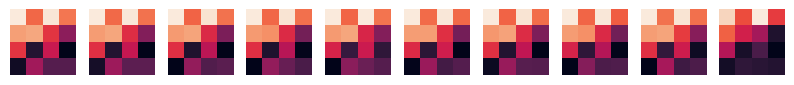


Epoch 26: val_loss improved from 112.90224 to 112.89292, saving model to models/model.112.9.keras
469/469 [==============================] - 7s 14ms/step - loss: 105.9277 - val_loss: 112.8929
Epoch 27/30
469/469 [==============================] - ETA: 0s - loss: 105.8870Embedding variances:


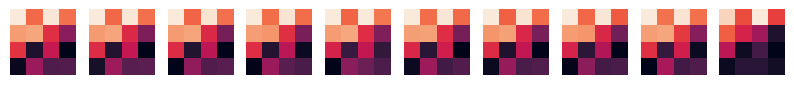


Epoch 27: val_loss did not improve from 112.89292
469/469 [==============================] - 7s 15ms/step - loss: 105.8870 - val_loss: 113.1376
Epoch 28/30
464/469 [============================>.] - ETA: 0s - loss: 105.8326Embedding variances:


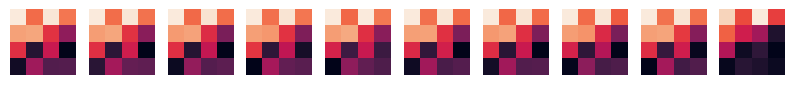


Epoch 28: val_loss did not improve from 112.89292
469/469 [==============================] - 6s 13ms/step - loss: 105.8223 - val_loss: 112.9896
Epoch 29/30
466/469 [============================>.] - ETA: 0s - loss: 105.7813Embedding variances:


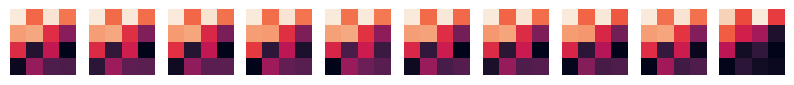


Epoch 29: val_loss improved from 112.89292 to 112.87609, saving model to models/model.112.9.keras
469/469 [==============================] - 6s 14ms/step - loss: 105.7704 - val_loss: 112.8761
Epoch 30/30
468/469 [============================>.] - ETA: 0s - loss: 105.7522Embedding variances:


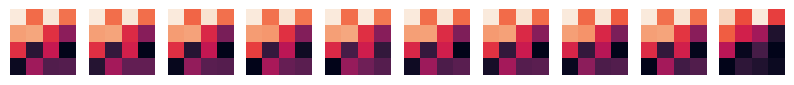


Epoch 30: val_loss improved from 112.87609 to 112.81172, saving model to models/model.112.8.keras
469/469 [==============================] - 6s 14ms/step - loss: 105.7405 - val_loss: 112.8117


In [24]:
print(f"prior means: {prior.mean()}")
print(f"prior variances: {prior.variance()}")

vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0])) if not 'vae' in locals() else vae

print(f"vae: {vae}")
vae.summary()

negloglik = lambda x, rv_x: -rv_x.log_prob(x)
learning_rate = tfk.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.7e-3,
    decay_steps=1000,
    decay_rate=0.9)

vae.compile(optimizer=tfk.optimizers.Adam(learning_rate=learning_rate), loss=negloglik)
# vae.compile(optimizer=tfk.optimizers.Adam(learning_rate=2e-3),
#             loss=negloglik)

class ShowProgressImagesCallback(keras.callbacks.Callback):
    def __init__(self, model, validation_data, shuffle=True):
        super().__init__()
        self.model = model
        self.validation_data = validation_data
        self.shuffle = shuffle or False

    def on_epoch_end(self, epoch, logs=None):

        # Extract the encoder and decoder
        encoder_ = keras.Sequential(self.model.layers[:-1])
        encoder_.compile()
        decoder_input = keras.Input(shape=encoder_.output_shape[1:])
        decoder_output = self.model.layers[-1](decoder_input)
        decoder_ = keras.Model(inputs=decoder_input, outputs=decoder_output)
        decoder_.compile()

        # We'll just examine the first ten digits.
        if self.shuffle:
            if isinstance(self.shuffle, bool):
                x = next(iter(self.validation_data.shuffle(10000)))[0][:10]
            else:
                x = next(iter(self.validation_data.shuffle(self.shuffle)))[0][:10]
        else:
            x = next(iter(self.validation_data))[0][:10]

        if epoch % 10 == 0:
            print("Original:")
            display_imgs(x)

            print('Embedding:')
            encoder_ = keras.Sequential(self.model.layers[:-1])
            encoder_.compile()
            display_imgs(tf.reshape(encoder_(x).sample(), [-1, 4, 4, 1]), colorize='GnBu')
            print('Embedding means:')
            display_imgs(tf.reshape(encoder_(x).mean(), [-1, 4, 4, 1]), colorize='GnBu')

            print('Embedding modes:')
            display_imgs(tf.reshape(encoder_(x).mode(), [-1, 4, 4, 1]), colorize='GnBu')

        print(f'Embedding variances: {encoder_(x).variance().mean()}')
        display_imgs(tf.reshape(encoder_(x).variance(), [-1, 4, 4, 1]), colorize='rocket_r')

        if epoch % 10 == 0:
            xhat = self.model(x)
            assert isinstance(xhat, tfd.Distribution)

            print('Reconstructions:')
            display_imgs(xhat.sample())

            print('Decoded modes:')
            display_imgs(xhat.mode(), colorize='rocket_r')

            print('Decoded means:')
            display_imgs(xhat.mean(), colorize='GnBu')

            print('Decoded variances:')
            display_imgs(xhat.variance(), colorize='rocket_r')

            # Test the extracted models
            encoded_imgs = encoder_.predict(x, verbose=False)
            decoded_imgs = decoder_.predict(encoded_imgs, verbose=False)

            print('Confidence map?:')
            display_imgs(decoded_imgs, colorize='tab20c_r')

checkpoint_filepath = "models/model.{val_loss:.4}.keras"
checkpoint_callback = tfk.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# delete xhat
# xhat = vae(next(iter(eval_dataset))[0][:10])
# assert isinstance(xhat, tfd.Distribution)
print('Originals:')
display_imgs(next(iter(eval_dataset))[0][:10])
print('Reconstituted:')
display_imgs(vae(next(iter(eval_dataset))[0]).mean()[:10])
# print('Reconstituted from decoding the encoder:')
# display_imgs(decoder(encoder(next(iter(eval_dataset))[0]).mean())[:10], colorize='rocket_r')
# # print('Reconstituted from decoding the encoder:')
# # display_imgs(decoder(encoder(x).mean()).sample(), colorize='rocket_r')

# Extract the encoder and decoder
encoder_ = keras.Sequential(vae.layers[:-1])
encoder_.compile()
# print(f"encoder_: {encoder_.output_shape}")
decoder_input = keras.Input(shape=encoder_.output_shape[1:])
decoder_output = vae.layers[-1](decoder_input)
decoder_ = keras.Model(inputs=decoder_input, outputs=decoder_output)
decoder_.compile()

# Test the extracted models
encoded_imgs = encoder_.predict(next(iter(eval_dataset))[0][:10], verbose=False)
print(f"encoded_imgs: {encoded_imgs.shape}")

decoded_imgs = decoder_.predict(encoded_imgs, verbose=False)

# # Display results
# print('Originals:')
# display_imgs(next(iter(eval_dataset))[0][:10])
# print('Reconstituted:')
# display_imgs(vae.predict(next(iter(eval_dataset))[0]).mean()[:10])
print('Reconstituted from decoding the encoder:')
display_imgs(decoded_imgs, colorize='tab20c_r')


vae.fit(train_dataset,
        epochs=30, batch_size=batch_size,
        validation_data=eval_dataset,
        callbacks=[
            ShowProgressImagesCallback(vae, eval_dataset, shuffle=False),
            checkpoint_callback
        ])



In [ ]:
# We'll just examine ten random digits.
# xhat = vae(next(iter(eval_dataset))[0][:10])
# assert isinstance(xhat, tfd.Distribution)
# print('Originals:')
# display_imgs(next(iter(eval_dataset))[0][:10])
# print('Reconstructions:')
# display_imgs(xhat.sample())

# print('Decoded modes:')
# display_imgs(xhat.mode())

# print('Decoded means:')
# display_imgs(xhat.mean())

print('Embedding:')
encoded= encoder(next(iter(eval_dataset))[0][:10]).sample()
# reshape the last dimension from (16,) to (4,4)
encoded = tf.reshape(encoded, [-1, 4, 4, 1])
display_imgs(encoded)


In [8]:
vae.compile(optimizer=tfk.optimizers.Adam(learning_rate=2e-3),
            loss=negloglik)

vae.fit(train_dataset,
            epochs=15, batch_size=batch_size,
            validation_data=eval_dataset)


Epoch 1/15
469/469 [==============================] - 12s 14ms/step - loss: 122.6911 - val_loss: 121.2680
Epoch 2/15
469/469 [==============================] - 6s 12ms/step - loss: 121.1165 - val_loss: 120.8817
Epoch 3/15
469/469 [==============================] - 6s 12ms/step - loss: 120.9630 - val_loss: 121.5750
Epoch 4/15
469/469 [==============================] - 6s 12ms/step - loss: 120.7787 - val_loss: 121.4463
Epoch 5/15
469/469 [==============================] - 6s 12ms/step - loss: 120.5148 - val_loss: 121.1965
Epoch 6/15
469/469 [==============================] - 6s 12ms/step - loss: 120.2527 - val_loss: 120.3328
Epoch 7/15
469/469 [==============================] - 6s 12ms/step - loss: 120.1741 - val_loss: 120.6111
Epoch 8/15
469/469 [==============================] - 6s 12ms/step - loss: 119.9274 - val_loss: 120.2241
Epoch 9/15
469/469 [==============================] - 6s 12ms/step - loss: 119.7546 - val_loss: 120.5511
Epoch 10/15
469/469 [==============================] -

Randomly Generated Samples:


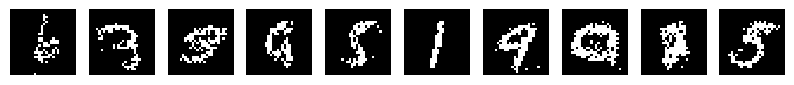

Randomly Generated Modes:


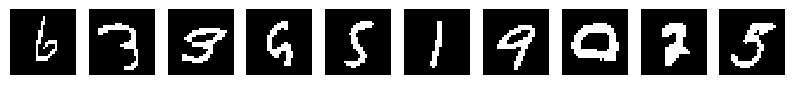

Randomly Generated Means:


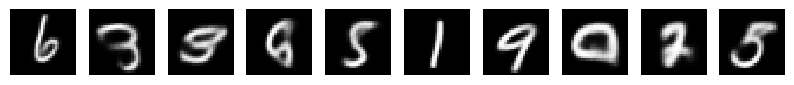

In [9]:
# Now, let's generate ten never-before-seen digits.
z = prior.sample(10)
xtilde = decoder(z)
assert isinstance(xtilde, tfd.Distribution)

print('Randomly Generated Samples:')
display_imgs(xtilde.sample())

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())


In [10]:

def pmf(k, lamb):
    return tf.exp(-lamb) * lamb**k / tf.math.factorial(k)


# Fusion of nonlinear state-space models and dynamic factor models


## _Nonlinear State-Space Models_

Nonlinear state-space models are used to describe systems where the relationship between the state variables and the observations is nonlinear. These models are represented by the following equations:

### State transition equation
$$
x_{t+1} = f(x_t, u_t) + w_t
$$

where:
- $x_{t}$ is the state vector at time $t$
- $u_{t}$ is the input vector at time $t$
- $f$ is a nonlinear function
- $w_{t}$ is process noise at time $t$


### Observation equation
$$
y_t = h(x_t) + v_t
$$

where:
- $y_{t}$ is the observation vector at time $t$
- $h$ is a nonlinear function
- $v_{t}$ is observation noise at time $t$


## _Dynamic Factor Models_

Dynamic factor models decompose the observed variables into a small number of latent factors that capture the common dynamics among the variables. The basic form of a DFM is:

### State transition equation
$$
y_t = \Lambda f_t + \epsilon_t
$$

where:
- $y_{t}$ is the observation vector at time $t$
- $\Lambda$ is the loading matrix
- $f_t$ is the vector of latent factors
- $\epsilon_t$ is the idiosyncratic error

### State transition equation for factors
$$
f_t = \Phi f_{t-1} + \eta_t
$$

where:
- $f_t$ is the vector of latent factors
- $\Phi$ is the transition matrix for the factors
- $\eta_t$ is the factor innovation

## _Nonlinear State-Space + Dynamic Factor Models_

To fuse these two approaches, we can represent the latent factors of the DFM within a nonlinear state-space framework. This involves defining the latent factors as the state variables in the state-space model:

### State transition equation
$$
f_{t+1} = \Phi f_t + g(f_t, u_t) + \eta_t
$$

Here, $g(f_t, u_t)$ is a nonlinear function capturing the dynamics influenced by the inputs $u_t$.

### Observation equation
$$
y_t = \Lambda f_t + h(f_t) + \epsilon_t
$$

The function $h(f_t)$ captures the nonlinear relationship between the factors and the observed variables.

## Estimation techniques

The Unscented Kalman Filter provides an accurate approximation for nonlinear transformations by using a deterministic sampling approach.


In [11]:
# we'll need to learn:
# $\Phi$, the transition matrix for the factors
# $f_{t}$, the vector of latent factors
# $\eta_t$, factor innovation
# $\Lambda$, the loading matrix
# $g(f_t, u_t)$, the nonlinear function capturing the dynamics influenced by the inputs
# $h(f_t)$, the nonlinear relationship between the factors and the observed variables

# yikes

n_features = 2 # Number of observed features
# n_factors = 5   # Number of latent factors
timesteps = 24  # Number of timesteps in the time series window


In [12]:


# Define the transition and observation functions
def transition_fn(x):
    # Nonlinear state-space model
    print(f"x: {x}")
    if all([z==0. for z in x]):
        return x
    # raise NotImplementedError
    return tfd.MultivariateNormalDiag(
        tf.stack([x[..., 0] - 0.1 * x[..., 1]**3, x[..., 1]], axis=-1),
        scale_diag=[0.7, 0.2]
    )

#
def transition_jacobian_fn(x):
    return tf.reshape(
        tf.stack([
            1. - 0.1 * x[..., 1]**3, -0.3 * x[..., 1]**2,
            tf.zeros(x.shape[:-1]), tf.ones(x.shape[:-1])
        ], axis=-1),
        [2, 2]
    )

def observation_fn(x):
    return tfd.MultivariateNormalDiag(
        x[..., :(n_features-1)],
        scale_diag=[1. for _ in range(n_features-1)])

def observation_jacobian_fn(x):
    return [[1. if j == 0 else 0. for j in range(n_features)]]

# Initial state prior
initial_state_prior = tfd.MultivariateNormalDiag(
    loc=[0. for _ in range(n_features)],
    scale_diag=[tf.exp(0.-0.5*x) for x in range(n_features)])

print(f"initial_state_prior: {initial_state_prior.sample()}")

# Observations (synthetic data for demonstration)
observations = observation_fn(tf.stack([initial_state_prior.sample() for _ in range(timesteps*2)])).sample()
print(f"observations: {observations.shape}")

# Apply the Extended Kalman Filter
results = tfp.experimental.sequential.extended_kalman_filter(
    observations=observations,
    initial_state_prior=initial_state_prior,
    transition_fn=transition_fn,
    observation_fn=observation_fn,
    transition_jacobian_fn=transition_jacobian_fn,
    observation_jacobian_fn=observation_jacobian_fn
)

# print(f"{[result for result in results]}")
# raise ValueError("Not implemented")
# print("Filtered state means:", results)

@keras.utils.register_keras_serializable()
class EKFLayer(Layer):
    def __init__(self, transition_fn, observation_fn, transition_jacobian_fn, observation_jacobian_fn, state_prior=None, **kwargs):
        super(EKFLayer, self).__init__(**kwargs)
        self.transition_fn = transition_fn
        self.observation_fn = observation_fn
        self.transition_jacobian_fn = transition_jacobian_fn
        self.observation_jacobian_fn = observation_jacobian_fn
        self.state_prior = state_prior

    def build(self, input_shape):
        print(f"input_shape: {input_shape}")
        if input_shape[0] is not None:
            raise ValueError("Expected to be built with input_shape=(None, ...)")
        self.state_prior = self.add_weight(
            name="state_prior",
            shape=(input_shape[-2], input_shape[-1]),
            trainable=True,
            dtype=self.dtype)
        self.transition_matrix = self.add_weight(
            name="transition_matrix",
            shape=(input_shape[-1], input_shape[-1]),
            trainable=True,
            dtype=self.dtype)
        self.latent_factors = self.add_weight(
            name="latent_factors",
            shape=(input_shape[-1],),
            trainable=True,
            dtype=self.dtype)
        # if input_shape[0] is None:
        #     raise ValueError("inputs must be a tuple of (observations, initial_state)")
        # self.observation_matrix =
        # self.initial_state_prior =
        # self.transition_jacobian =
        # self.observation_jacobian =
        # self.factor_innovation =
        # self.loading_matrix =
        # self.nonlinear_function =
        # self.nonlinear_relationship =
        # self.latent_factors =
        # self.factor_innovation = self.add_weight(
        #     name="factor_innovation",
        #     shape=(input_shape[0],),
        #     dtype=self.dtype)
        super(EKFLayer, self).build(input_shape)

    def call(self, inputs):
        if inputs.shape[0] is None:
            print("Warning, inputs.shape[0] is None")
            # raise ValueError("inputs must be a tuple of (observations, initial_state)")
            return inputs
        print(f"inputs: {inputs}")
        observations = inputs
        results = tfp.experimental.sequential.extended_kalman_filter(
            observations=observations,
            initial_state_prior=self.state_prior,
            transition_fn=self.transition_fn,
            observation_fn=self.observation_fn,
            transition_jacobian_fn=self.transition_jacobian_fn,
            observation_jacobian_fn=self.observation_jacobian_fn
        )
        return results[0]

# Create the custom EKF layer
ekf_layer = EKFLayer(transition_fn, observation_fn,
                     transition_jacobian_fn, observation_jacobian_fn,
                     state_prior=initial_state_prior)

# Example usage in a Keras model
inputs = tf.keras.Input(shape=(timesteps, n_features))
ekf = ekf_layer(inputs)
model = tf.keras.Model(inputs=inputs, outputs=ekf)
model.summary()

@keras.utils.register_keras_serializable()
def custom_loss(y_true, y_pred):
    # Example: Mean Squared Logarithmic Error to handle skewness
    return K.mean(K.square(K.log(1 + y_true) - K.log(1 + y_pred)), axis=-1)

# Compile the model with the custom loss function
model.compile(optimizer='adam', loss=custom_loss)

# summary
model.summary()

# Generate some example data
X_train = np.random.rand(100000, timesteps, n_features)
y_train = np.random.rand(100000, timesteps, n_features)

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.2)
print(f'Training loss: {history.history["loss"][-1]}')
print(f'Validation loss: {history.history["val_loss"][-1]}')

# Generate some example test data
X_test = np.random.rand(200, timesteps, n_features)
y_test = np.random.rand(200, timesteps, n_features)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)
print(f'Predictions: {predictions}')

model.save("model.keras")

del model
model = tf.keras.models.load_model("model.keras")
model.summary()




initial_state_prior: [-2.1426442 -0.529029 ]
observations: (48, 1)
x: [0. 0.]


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'covariance'

In [ ]:


@keras.utils.register_keras_serializable()
class NonlinearStateSpaceDynamicFactorModel(tf.keras.models.Model):
    def __init__(factors=None, **kwargs):
        super().__init__(**kwargs)
        self.factors = factors
        self.phi = None # transition matrix for factors
        self.latent_factors = None # vector of latent factors
        self.factor_innovation = None
        self.loading_matrix = None
        self.nonlinear_function = None
        self.nonlinear_relationship = None

    def build(self, input_shape):
        # self.factors =
        # if self.factors is None:
        #     # TODO: support learning the number of factors
        #     raise ValueError("factors must be specified")

        self.factor_innovation = self.add_weight(
            name="factor_innovation",
            shape=(input_shape[-1],),
            dtype=self.dtype)

        super().build(input_shape)

    def call(self, inputs):
        raise NotImplementedError

    def get_config(self):
        config = super().get_config()
        config.update({
            "factors": self.factors
        })
        return config

    def get_weights(self):
        raise NotImplementedError

    def set_weights(self, weights):
        raise NotImplementedError

    @classmethod
    def from_config(cls, config):
        if "factors" in config:
            factors = config.pop("factors")
        else:
            factors = None
        return cls(factors, **config)

    def from_json(cls, json_config):
        config = json.loads(json_config)
        return cls(**config)


@keras.utils.register_keras_serializable()
class SVDLayer(keras.layers.Layer):
    """
    A layer that keeps its weights Singular Value Decomposed.

    Attributes:
      output_dim: dimensions of the output space
      rank: rank of the SVD decomposition
      activation: activation function to apply to the output
      seed: seed for any random features
      U: rotation weights matrix
      S: singular values matrix
      V: rotation weights matrix
    """
    def __init__(self, output_dim,
                 rank=None, low_rank=None, activation='relu',
                 s_regularizer=None, s_initializer=None,
                 u_regularizer=None, u_initializer=None,
                 v_regularizer=None, v_initializer=None,
                 b_regularizer=None, b_initializer=None,
                 seed=None,
                 **kwargs):
        super(SVDLayer, self).__init__(**kwargs)
        # if output_dim is None:
        #     # TODO: allow automatically configuring the output dimension
        #     raise ValueError("output_dim must be specified")
        # self.output_dim = output_dim
        # self.rank = rank if rank is not None else output_dim
        # self.low_rank = low_rank if low_rank is not None else self.rank
        # self.seed = seed

        # self.activation = keras.activations.get(activation) or keras.activations.linear

        # self.s_initializer = keras.initializers.get(s_initializer) or keras.initializers.Ones()
        # self.u_initializer = keras.initializers.get(u_initializer) or keras.initializers.Orthogonal()
        # self.v_initializer = keras.initializers.get(v_initializer) or keras.initializers.Orthogonal()
        # self.b_initializer = keras.initializers.get(b_initializer) or keras.initializers.Zeros()

        # self.s_regularizer = keras.regularizers.get(s_regularizer)
        # self.u_regularizer = keras.regularizers.get(u_regularizer) or keras.regularizers.orthogonal_regularizer(0.1, mode='columns')
        # self.v_regularizer = keras.regularizers.get(v_regularizer) or keras.regularizers.orthogonal_regularizer(0.1, mode='rows')
        # self.b_regularizer = keras.regularizers.get(b_regularizer)
        raise NotImplementedError

    def compute_output_shape(self, input_shape):
        # # TODO: verify this is correct
        # return (input_shape[0], self.output_dim)
        raise NotImplementedError

    @tf.function(input_signature=[tf.TensorSpec(shape=None, dtype=tf.float32)])
    def call_and_return_dict(self, inputs):
        # return {"output": self.call(inputs)}
        raise NotImplementedError

    def get_config(self):
        config = super().get_config()
        # config.update({
        #     "output_dim": self.output_dim,
        #     "rank": self.rank,
        #     "low_rank": self.low_rank,
        #     "seed": self.seed,
        #     "activation": keras.activations.serialize(self.activation),
        #     "s_regularizer": keras.regularizers.serialize(self.s_regularizer),
        #     "s_initializer": keras.initializers.serialize(self.s_initializer),
        #     "u_regularizer": keras.regularizers.serialize(self.u_regularizer),
        #     "u_initializer": keras.initializers.serialize(self.u_initializer),
        #     "v_regularizer": keras.regularizers.serialize(self.v_regularizer),
        #     "v_initializer": keras.initializers.serialize(self.v_initializer),
        #     "b_regularizer": keras.regularizers.serialize(self.b_regularizer),
        #     "b_initializer": keras.initializers.serialize(self.b_initializer),
        # })
        return config

    def get_weights(self):
        # return [self.U.numpy(), self.S.numpy(), self.V.numpy(), self.b.numpy()]
        raise NotImplementedError

    def set_weights(self, weights):
        # self.U.assign(weights[0])
        # self.S.assign(weights[1])
        # self.V.assign(weights[2])
        # self.b.assign(weights[3])
        raise NotImplementedError

    def build(self, input_shape):
        # # print(f"SVDLayer.build(): input_shape={input_shape}")
        # # TODO: add support for other, such as, complex types

        # if self.rank is None:
        #     self.rank = math.min(input_shape[-1], self.output_dim)
        #     print(f"SVDLayer        : rank={self.rank}")

        # if self.low_rank is None or self.low_rank > self.rank:
        #     self.low_rank = self.rank
        #     print(f"SVDLayer        : low_rank={self.low_rank}")

        # # Initialize U, Σ, and V
        # self.U = self.add_weight(name="U", #dtype=dtype,
        #                          shape=(input_shape[-1], self.rank),
        #                          initializer=self.u_initializer,
        #                          regularizer=self.u_regularizer,
        #                          constraint=keras.constraints.UnitNorm(axis=0),
        #                          trainable=True)

        # self.S = self.add_weight(name="S", #dtype=dtype,
        #                          shape=(self.rank,),
        #                          initializer=self.s_initializer,
        #                          regularizer=self.s_regularizer,
        #                          constraint=UniqueNonZero(),
        #                          trainable=True)

        # self.V = self.add_weight(name="V", #dtype=dtype,
        #                          shape=(self.rank, self.output_dim),
        #                          initializer=self.v_initializer,
        #                          regularizer=self.v_regularizer,
        #                          constraint=keras.constraints.UnitNorm(axis=1),
        #                          trainable=True)

        # self.b = self.add_weight(name="bias", #dtype=dtype,
        #                          shape=(self.output_dim,),
        #                          initializer=self.b_initializer,
        #                          regularizer=self.b_regularizer,
        #                          trainable=True)
        raise NotImplementedError

    def call(self, inputs):
        # # # Flatten input if it's not 2D
        # # original_shape = tf.shape(inputs)
        # # if len(inputs.shape) > 2:
        # #     inputs = tf.reshape(inputs, (-1, inputs.shape[-1]))

        # # Reconstruct the weight matrix (or a low-rank approximation)
        # U = self.U[:, :self.low_rank]
        # S = self.S[:self.low_rank]
        # V = self.V[:self.low_rank, :]

        # w = keras.ops.matmul(keras.ops.multiply(U, S), V)

        # result = keras.ops.add(keras.ops.matmul(inputs, w), self.b)

        # # # Reshape result if input was not 2D
        # # if len(original_shape) > 2:
        # #     new_shape = tf.concat([original_shape[:-1], [self.output_dim]], axis=0)
        # #     result = tf.reshape(result, new_shape)

        # return self.activation(result)
        raise NotImplementedError




In [ ]:
n_features = 10 # Number of observed features
n_factors = 5   # Number of latent factors
timesteps = 24  # Number of timesteps in the time series window

# define the inputs
input_layer = Input(shape=(timesteps, n_features))

# LSTM layer to capture the temporal dynamics of the latent factors
lstm_layer = LSTM(n_factors, return_sequences=True)(input_layer)

# layer for nonlinear relations between factors and observed variables
dense_layer = Dense(n_features)(lstm_layer)

# define the model
model = Model(input_layer, dense_layer)

@keras.utils.register_keras_serializable()
def custom_loss(y_true, y_pred):
    # Example: Mean Squared Logarithmic Error to handle skewness
    return K.mean(K.square(K.log(1 + y_true) - K.log(1 + y_pred)), axis=-1)

# Compile the model with the custom loss function
model.compile(optimizer='adam', loss=custom_loss)

# summary
model.summary()

# Generate some example data
X_train = np.random.rand(10000, timesteps, n_features)
y_train = np.random.rand(10000, timesteps, n_features)

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.2)
print(f'Training loss: {history.history["loss"][-1]}')
print(f'Validation loss: {history.history["val_loss"][-1]}')

# Generate some example test data
X_test = np.random.rand(200, timesteps, n_features)
y_test = np.random.rand(200, timesteps, n_features)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)
print(f'Predictions: {predictions}')

model.save("model.keras")

del model
model = tf.keras.models.load_model("model.keras")
model.summary()



In [ ]:
from IPython.display import display
with pd.option_context('display.max_columns', 240):
    display(model.weights)

In [ ]:
import numpy as np
import tensorflow as tf

def sliding_window_generator(data, targets, window_size, stride, batch_size):
    num_samples = (len(data) - window_size) // stride + 1
    while True:
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_data = []
            batch_targets = []
            for i in range(start, end):
                window_start = i * stride
                window_end = window_start + window_size
                batch_data.append(data[window_start:window_end])
                batch_targets.append(targets[window_end-1])
            yield np.array(batch_data), np.array(batch_targets)

# Example data
data = np.arange(100)
targets = data * 2  # Dummy target values

# Parameters
window_size = 10
stride = 1
batch_size = 32

# Create the generator
generator = sliding_window_generator(data, targets, window_size, stride, batch_size)

# Create a Keras model for demonstration
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(window_size,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss=custom_loss)

# Train the model using the generator
model.fit(generator, steps_per_epoch=(len(data) - window_size) // stride // batch_size, epochs=10)

# Moving Average Layer

In [ ]:

# with input shape (None, input_size, 1)
# output shape is (None, input_size, 1*len(periods))


# The MovingAverageLayer calculates the moving average of each input &
# outputs a new feature for each input and period
@keras.utils.register_keras_serializable()
class MovingAverageLayer(tf.keras.layers.Layer):
    def __init__(self, periods=range(2,5), **kwargs):
        super().__init__(**kwargs)
        if not isinstance(periods, list):
            if isinstance(periods, int):
                self.periods = [periods]
            elif isinstance(periods, range):
                self.periods = list(periods)
            else:
                raise ValueError("periods must be an int or list of ints")
        else:
            if not all(isinstance(period, int) for period in periods):
                raise ValueError(f"periods must be a list of all ints ({[p for p in periods]})")
            self.periods = periods
        self.output_shape = None
        self.avg_layers = [tf.keras.layers.AveragePooling1D(period) for period in self.periods]
        print(f"periods: {[p for p in self.periods]}")

    def build(self, input_shape):
        self.output_shape = input_shape + (len(self.periods),)
        print(f"input_shape: {input_shape}")
        print(f"output_shape: {self.output_shape}")
        super().build(input_shape)

    def output_shape(self):
        return self.output_shape

    def call(self, inputs):
        # inputs shape: (batch_size, input_size, 1)
        # output shape: (batch_size, input_size, 1*len(periods))
        outputs = tf.expand_dims(inputs, axis=-1)

        # for each input, calculate the moving average and append it to the output
        output = []
        for input in inputs:
            for avg_layer in self.avg_layers:
                output.append(avg_layer(tf.expand_dims(input, axis=0)))

        # output shape: (batch_size, input_size, 1*len(periods))
        output = tf.stack(output, axis=-1)
        return output

    def get_config(self):
        config = super().get_config()
        config.update({
            "periods": self.periods
        })
        return config

tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(72,7)),
    MovingAverageLayer([2]),
    tf.keras.layers.Dense(1)
]).plot_model(MovingAverageLayer([5,10]), show_shapes=True)


In [ ]:
tf.expand_dims([[1,2,3],[2,4,5]], axis=-1).shape


# Get ticker data

In [ ]:

def date_to_str(date):
    return date.strftime("%Y-%m-%d")


In [ ]:

def get_ticker_data(symbol, start="2000-01-01", end=date.today()):
    try:
        # data = yf.Ticker(symbol)
        data = yf.download(symbol, start=start, end=end)
        print(f"Downloaded data for {symbol}")
        print(f"data.shape: {data.shape}")
        print(f"data.T: {data.T}")
        print(f"data.describe: {data.describe()}")
        print(f"data.head(): {data.head()}")
        data = (
            data[:]
            .rename(columns={"Open": "open", "High": "high", "Low": "low", "Close": "close"})
        )
        # hist = data.history(start=start, end=end, interval="1d")
        # data = data[:,~data.isna()]
        diff = data.diff()
        print(f"diffs: {diff.head()}")
        data = data.reset_index()
        print(f"data: {diff.head()}")
        # add returns column to data
        data['returns_1d'] = diff['Adj Close']
        # data['returns_1d'] = diff.values
        print(f"data with returns: {diff.head()}")
        data.Date = data.Date.apply(lambda d: d.date())
        print(f"returning data: {diff.head()}")
        return data.dropna()
    except Exception as e:
        print(f"caught exception: {e}")
        return None

def test_get_ticker_data():
    print("Getting ticker")
    hist = get_ticker_data("AAPL")
    print(f"Got history: {hist}")
    print(hist.head())
    assert hist is not None
    assert len(hist.values) > 0
    print(hist.columns)
    assert hist.columns.tolist() == ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Price change']
    assert hist.Date.dtype == np.datetime64
    assert hist.Open.dtype == np.float64
    assert hist.High.dtype == np.float64
    assert hist.Low.dtype == np.float64
    assert hist.Close.dtype == np.float64
    assert hist.Volume.dtype == np.float64
    assert hist['price change'].dtype == np.float64
    assert hist.shape[0] > 0
    assert hist.shape[1] == 7

test_get_ticker_data()




# Simple trading strategy class

In [ ]:
from typing import Callable, Tuple

class Strategy:
    def __init__(self, buy_cond: Tuple|Callable, sell_cond: Tuple|Callable):
        if type(buy_cond) == tuple and len(buy_cond) == 2:
            buy_cond = lambda: buy_cond
        elif isinstance(buy_cond, Callable):
            # self.buy_cond = buy_cond
            pass
        else:
            raise ValueError("buy_cond must be a tuple or function")

        if type(sell_cond) == tuple and len(sell_cond) == 2:
            sell_cond = lambda: sell_cond
        elif isinstance(sell_cond, Callable):
            # self.sell_cond = sell_cond
            pass
        else:
            raise ValueError("sell_cond must be a tuple or function")

        buy_dir, buy_periods = buy_cond()
        sell_dir, sell_periods = sell_cond()

        if buy_dir not in ['increase', 'decrease']
            raise ValueError("buy_cond must have a buy direction")
        if sell_dir not in ['increase', 'decrease']
            raise ValueError("buy_cond must have a buy direction")
        if not isinstance(buy_periods, int) or buy_periods <= 0:
            raise ValueError("buy_periods must have a positive number of periods")
        if not isinstance(sell_periods, int) or sell_periods <= 0:
            raise ValueError("sell_periods must have a positive number of periods")

        self.buy_dir = buy_dir
        self.buy_periods = buy_periods
        self.sell_dir = sell_dir
        self.sell_periods = sell_periods




In [ ]:

def execute_strategy(history, strategy, verbose=1):
    initial_value = 100
    current_value = initial_value
    positions = []

    holding = False

    # number of bars since price has increased or decreased
    n_bars_dec = 0
    n_bars_inc = 0

    # backtest the strategy day-by-day
    for i, row in history.iterrows():

        if row.returns_1d < 0:
            n_bars_dec += 1
            n_bars_inc = 0
        else:
            n_bars_inc += 1
            n_bars_dec = 0

    if not holding:
        if (strategy.buy_dir == 'decrease' and n_bars_dec == strategy.buy_periods) or (strategy.buy_dir == 'increase' and n_bars_inc == strategy.buy_periods):


